In [38]:
import pandas as pd
import numpy as np
import scipy.stats as sta
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [39]:
train_df = pd.read_csv('D:/DataAnalysis/2019未来高校AI挑战赛_城市-房产租金预测/train_data.csv')
test_df = pd.read_csv('D:/DataAnalysis/2019未来高校AI挑战赛_城市-房产租金预测/test_a.csv')

In [40]:
print(train_df.shape)
print(test_df.shape)

(41440, 51)
(2469, 50)


In [41]:
train_df.head()

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney
0,100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,...,0,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28,2000.0
1,100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,...,0,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16,2000.0
2,100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,...,0,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22,16000.0
3,100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,...,332760000,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21,1600.0
4,100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,...,0,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18,2900.0


In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41440 entries, 0 to 41439
Data columns (total 51 columns):
ID                    41440 non-null int64
area                  41440 non-null float64
rentType              41440 non-null object
houseType             41440 non-null object
houseFloor            41440 non-null object
totalFloor            41440 non-null int64
houseToward           41440 non-null object
houseDecoration       41440 non-null object
communityName         41440 non-null object
city                  41440 non-null object
region                41440 non-null object
plate                 41440 non-null object
buildYear             41440 non-null object
saleSecHouseNum       41440 non-null int64
subwayStationNum      41440 non-null int64
busStationNum         41440 non-null int64
interSchoolNum        41440 non-null int64
schoolNum             41440 non-null int64
privateSchoolNum      41440 non-null int64
hospitalNum           41440 non-null int64
drugStoreNum       

## 1.测试集和训练集的空值统计

In [43]:
combine = [train_df,test_df]
for df in combine:
    Total = df.isnull().sum().sort_values(ascending=False)
    Percent = Total/df.isnull().count()
    Missing = pd.concat([Total,Percent],axis=1,keys=['Total','Percent'],sort=False)
    print('--------------------------------------')
    print(Missing[Missing.Total>0])

--------------------------------------
    Total   Percent
uv     18  0.000434
pv     18  0.000434
--------------------------------------
    Total  Percent
uv      2  0.00081
pv      2  0.00081


In [44]:
##fill with null values
fill_na = ['uv','pv']
for col_1 in fill_na:
    train_df[col_1].fillna(train_df[col_1].mean(),inplace=True)
    test_df[col_1].fillna(test_df[col_1].mean(),inplace=True)
    train_df[col_1] = train_df[col_1].astype(int)
    test_df[col_1] = test_df[col_1].astype(int)

## 2.预测变量的峰度和偏度分析

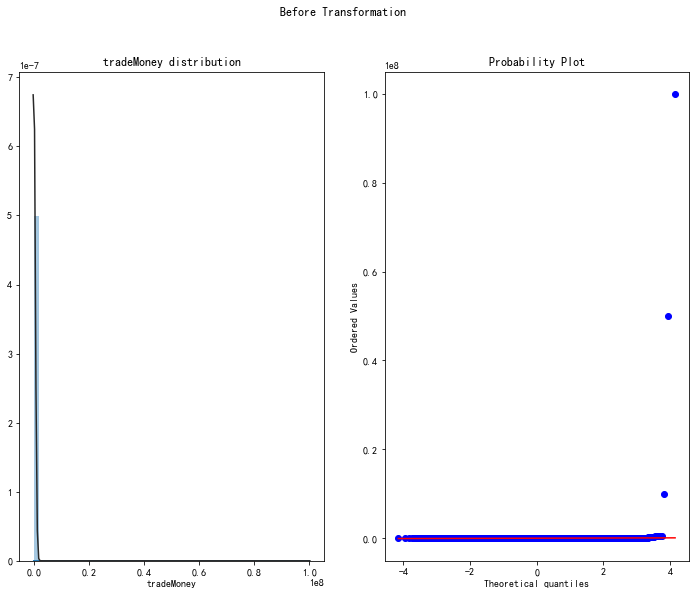

In [45]:
plt.rcParams['font.sans-serif']=['SimHei']##显示中文标签
plt.rcParams['axes.unicode_minus']=False##显示正负号
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,9))
sns.distplot(train_df['tradeMoney'],fit=norm,ax=ax1)
ax1.set_title('tradeMoney distribution')
sta.probplot(train_df['tradeMoney'],plot=ax2)
plt.suptitle('Before Transformation')
plt.show()

In [46]:
##使用孤立森林来检测异常值点
from sklearn.ensemble import IsolationForest
IForest = IsolationForest(contamination=0.02)
IForest.fit(train_df['tradeMoney'].values.reshape(-1,1))
ypred = IForest.predict(train_df['tradeMoney'].values.reshape(-1,1))
ypred

array([1, 1, 1, ..., 1, 1, 1])

In [47]:
drop_index = train_df[ypred==-1].index
train_df.drop(drop_index,axis=0,inplace=True)
train_df.shape

(40615, 51)

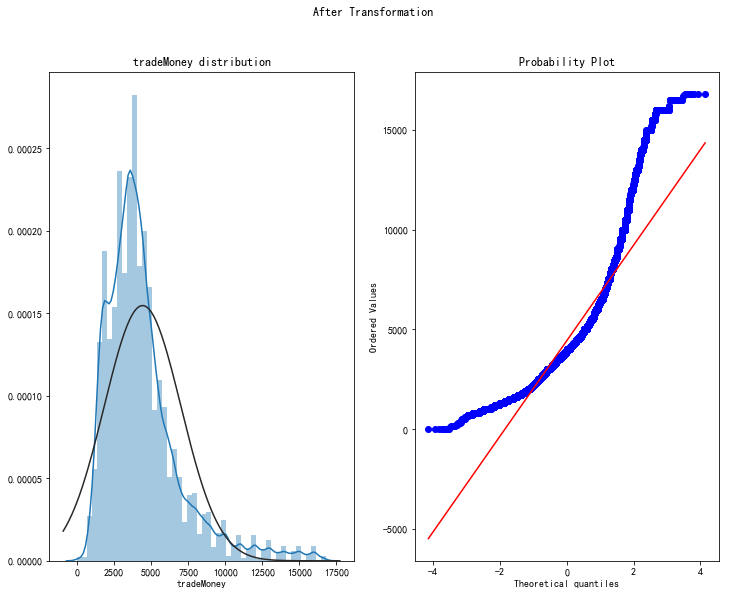

In [48]:
#train_df['tradeMoney'] = np.log1p(train_df['tradeMoney'])
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,9))
sns.distplot(train_df['tradeMoney'],fit=norm,ax=ax1)
ax1.set_title('tradeMoney distribution')
sta.probplot(train_df['tradeMoney'],plot=ax2)
plt.suptitle('After Transformation')
plt.show()

In [49]:
print('Skeness:%.3f'%train_df['tradeMoney'].skew())
print('Kurtness:%.3f'%train_df['tradeMoney'].kurt())

Skeness:1.745
Kurtness:4.017


## 3.Categorical特征nunique分布

In [50]:
categorical_col = [col for col in train_df.columns if train_df[col].dtypes=='object']
categorical_col

['rentType',
 'houseType',
 'houseFloor',
 'houseToward',
 'houseDecoration',
 'communityName',
 'city',
 'region',
 'plate',
 'buildYear',
 'tradeTime']

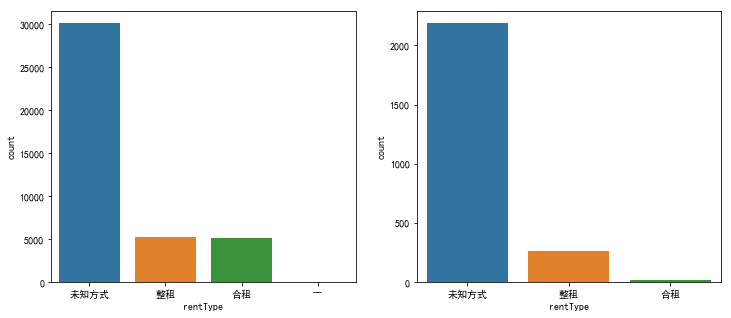

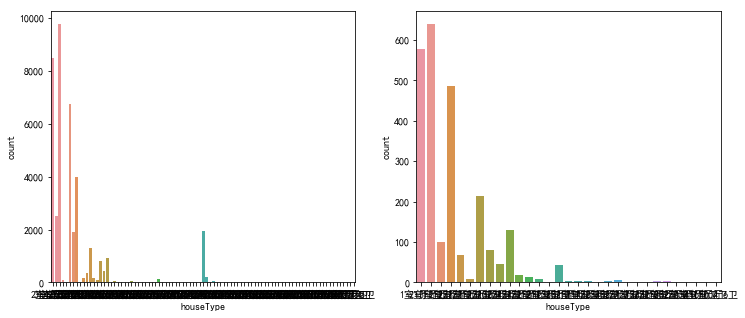

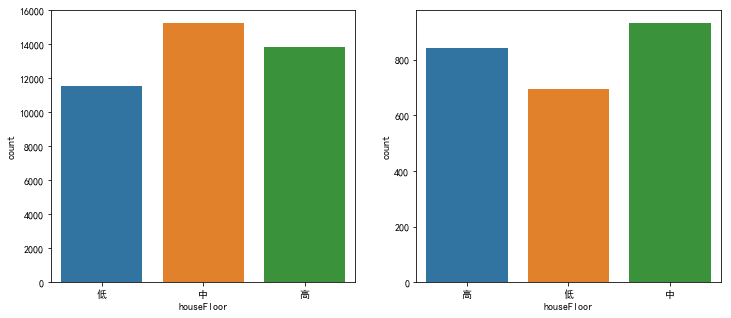

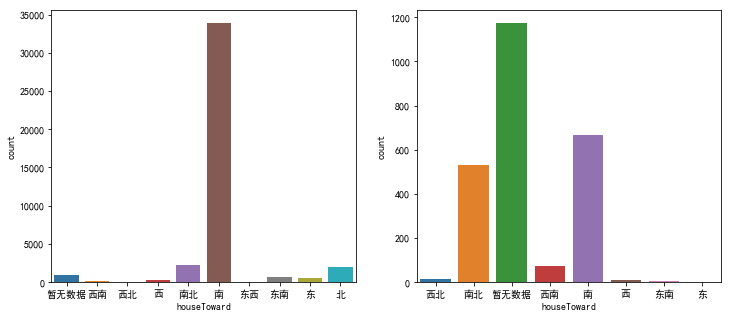

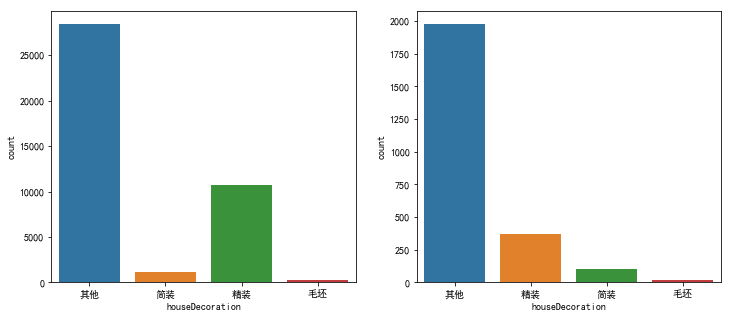

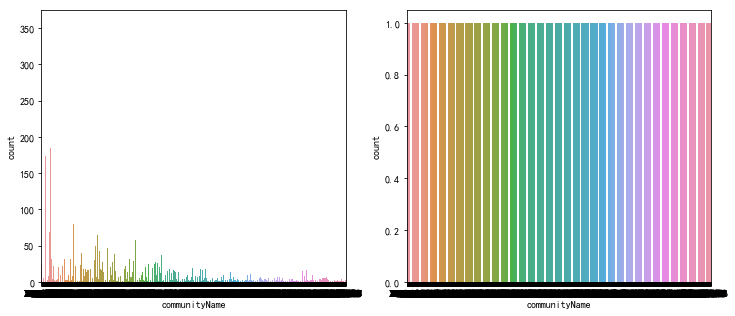

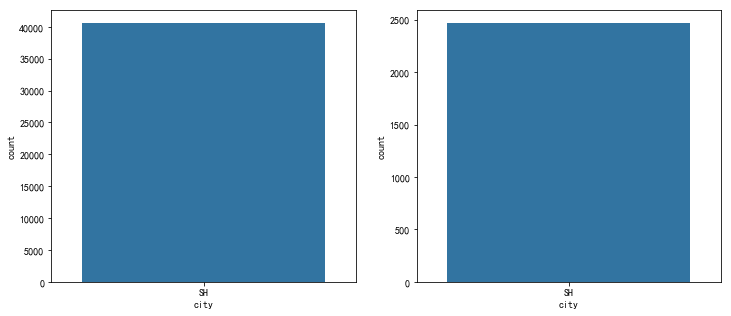

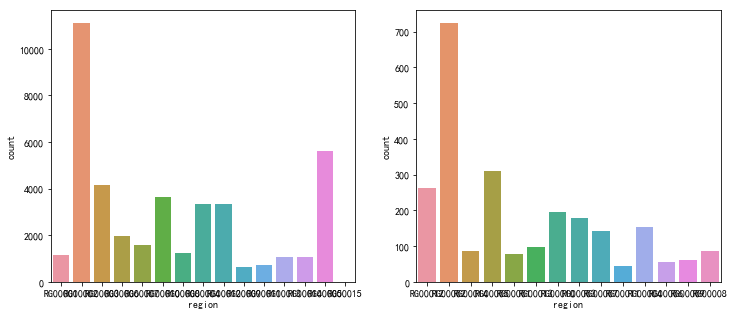

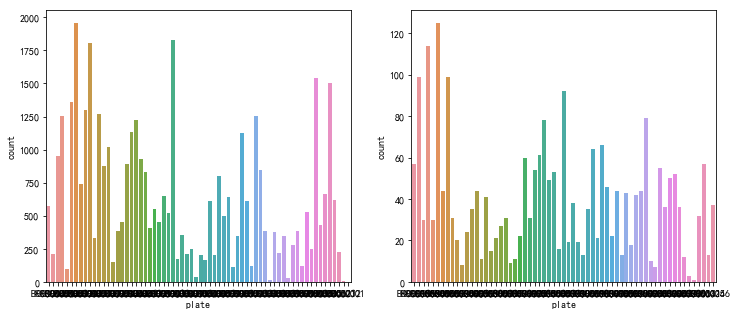

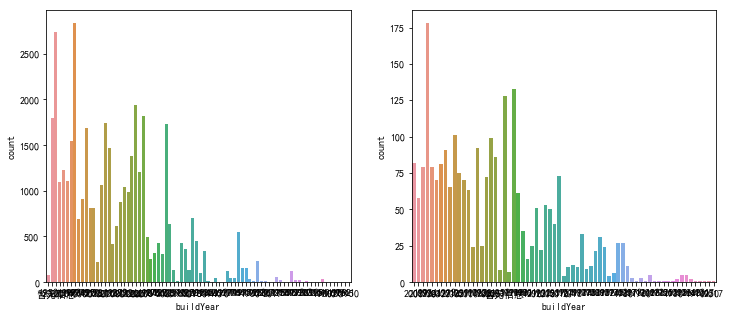

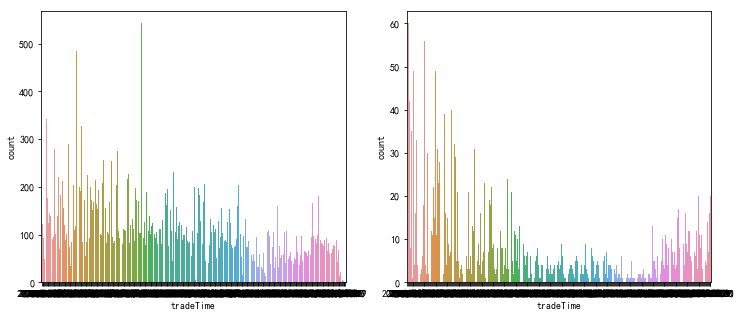

In [51]:
for col_2 in categorical_col:
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    sns.countplot(train_df[col_2],ax=ax1)
    sns.countplot(test_df[col_2],ax=ax2)
    plt.show()

## 4.Numerical特征的分布

In [52]:
numerical_col = [col for col in train_df.columns if train_df[col].dtypes!='object' and col not in ['ID','tradeMoney']]
numerical_col

['area',
 'totalFloor',
 'saleSecHouseNum',
 'subwayStationNum',
 'busStationNum',
 'interSchoolNum',
 'schoolNum',
 'privateSchoolNum',
 'hospitalNum',
 'drugStoreNum',
 'gymNum',
 'bankNum',
 'shopNum',
 'parkNum',
 'mallNum',
 'superMarketNum',
 'totalTradeMoney',
 'totalTradeArea',
 'tradeMeanPrice',
 'tradeSecNum',
 'totalNewTradeMoney',
 'totalNewTradeArea',
 'tradeNewMeanPrice',
 'tradeNewNum',
 'remainNewNum',
 'supplyNewNum',
 'supplyLandNum',
 'supplyLandArea',
 'tradeLandNum',
 'tradeLandArea',
 'landTotalPrice',
 'landMeanPrice',
 'totalWorkers',
 'newWorkers',
 'residentPopulation',
 'pv',
 'uv',
 'lookNum']

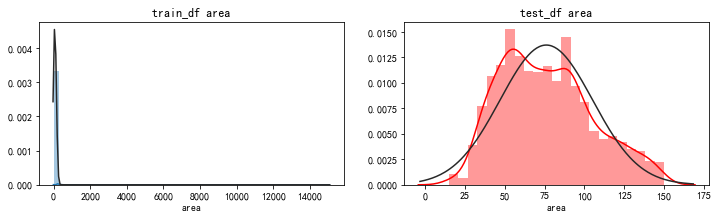

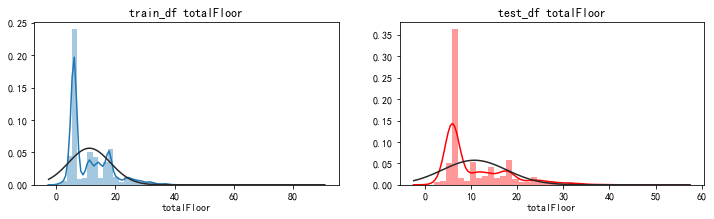

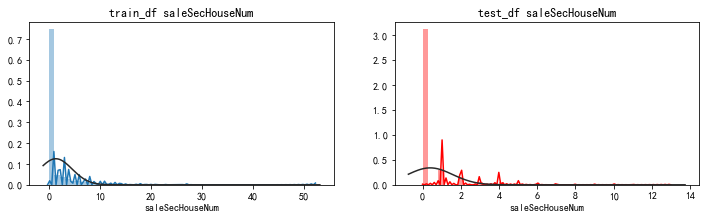

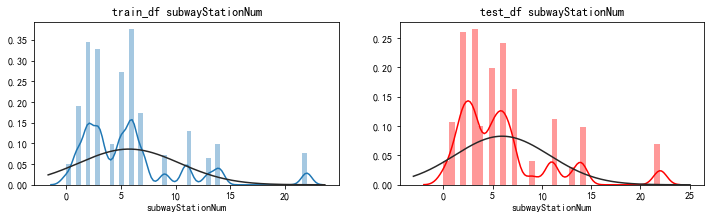

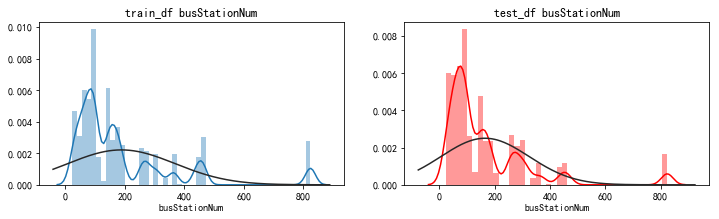

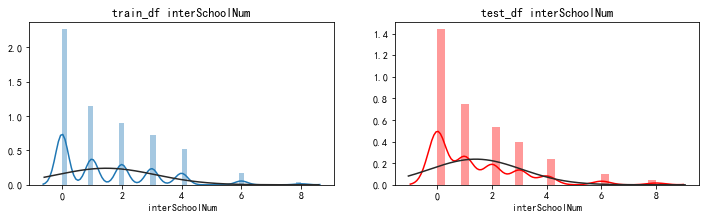

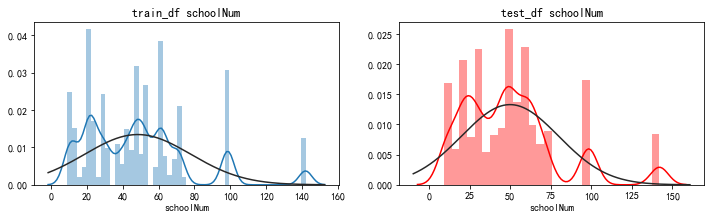

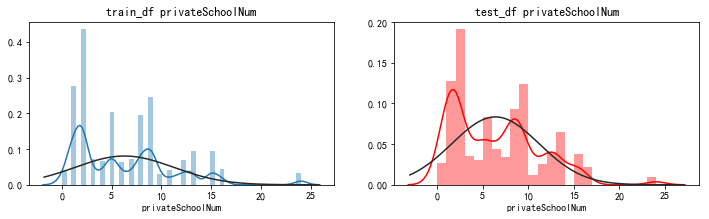

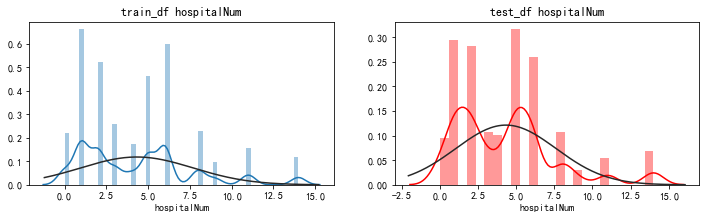

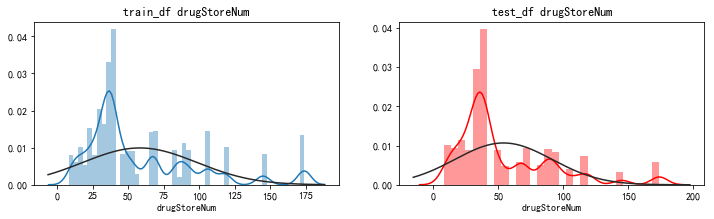

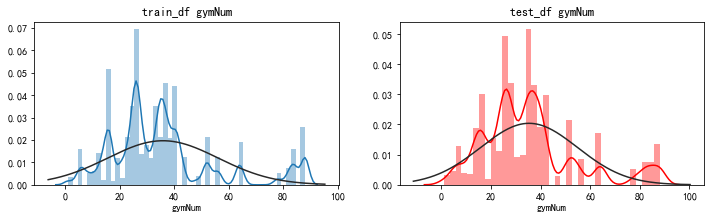

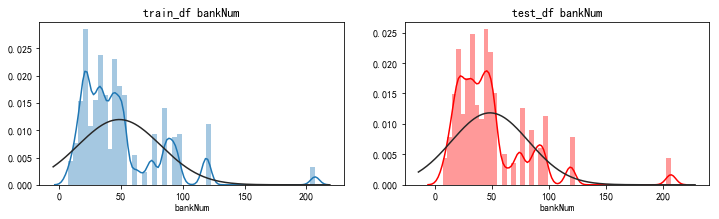

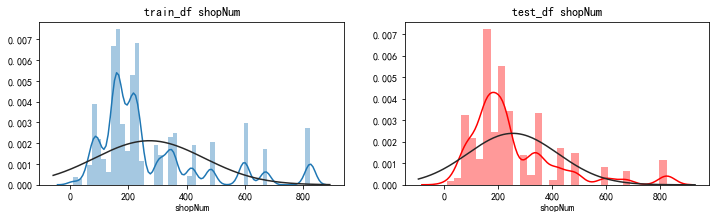

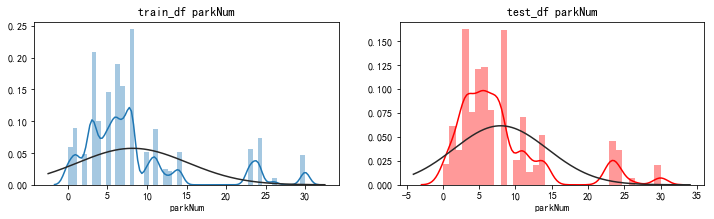

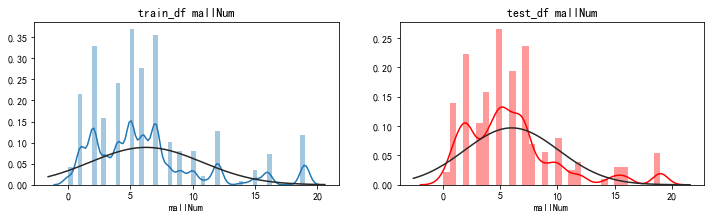

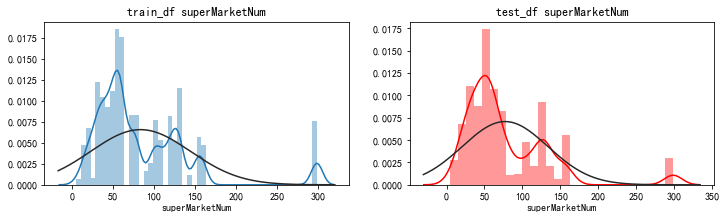

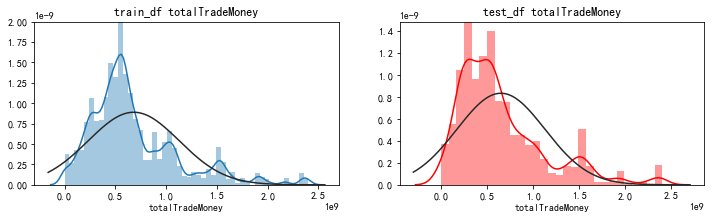

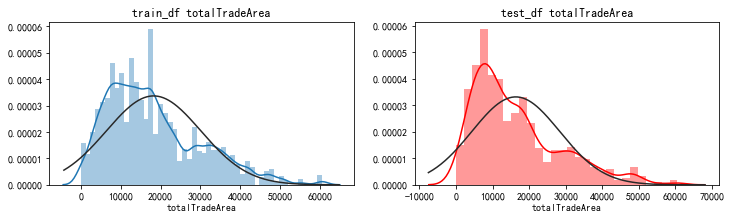

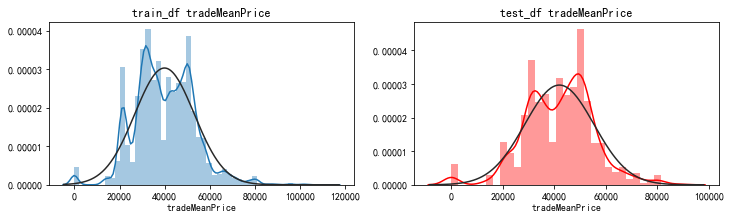

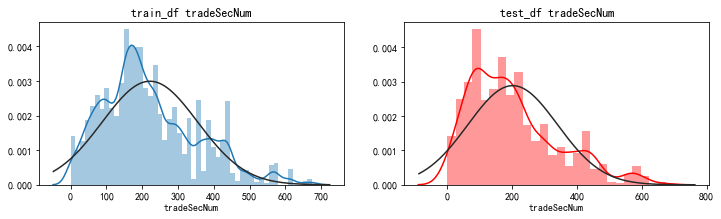

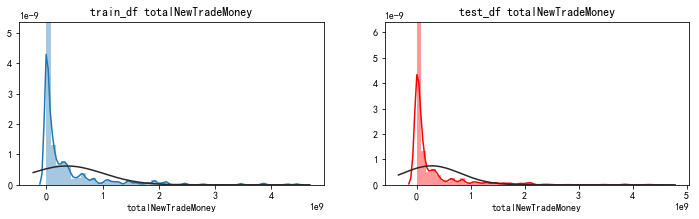

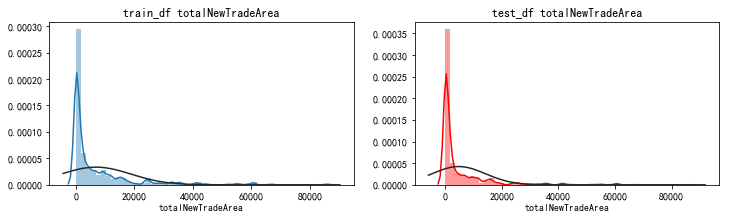

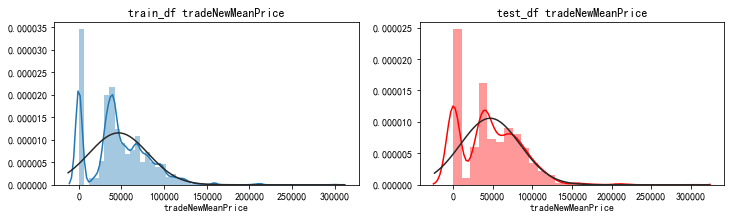

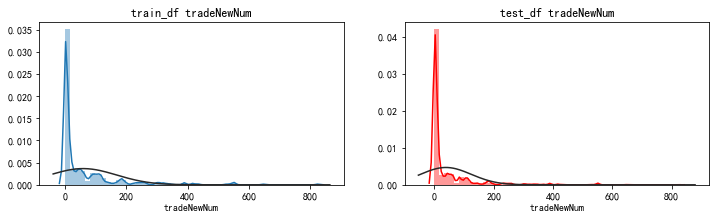

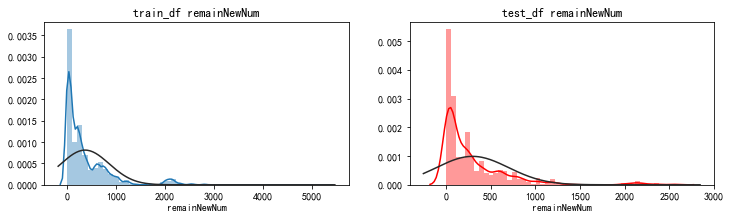

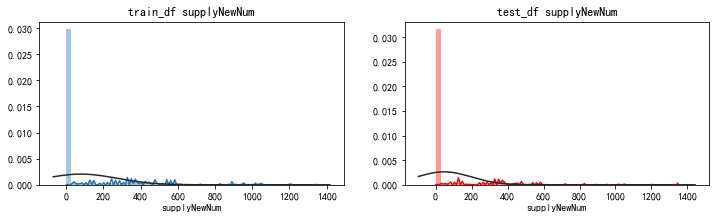

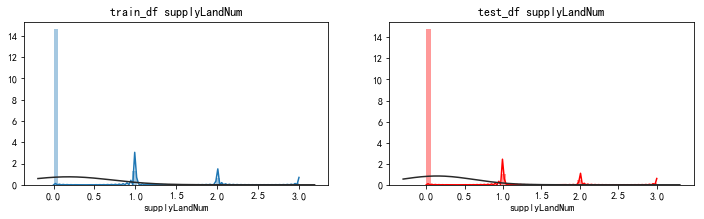

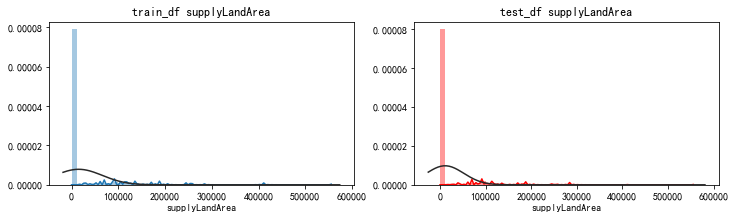

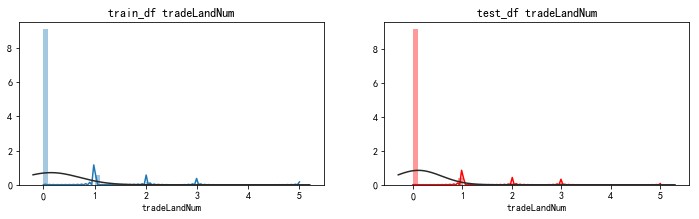

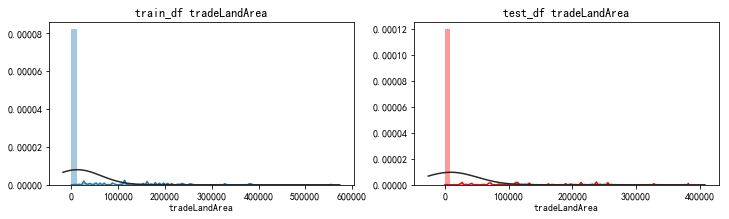

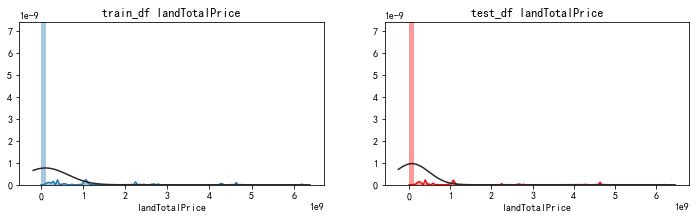

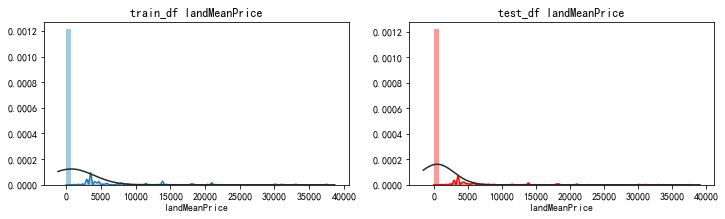

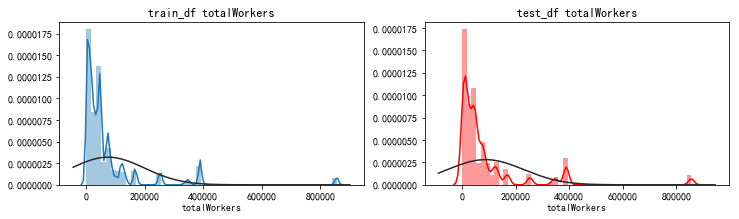

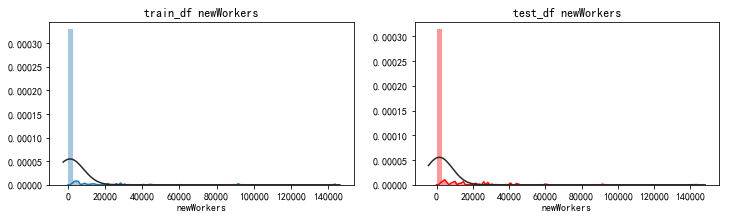

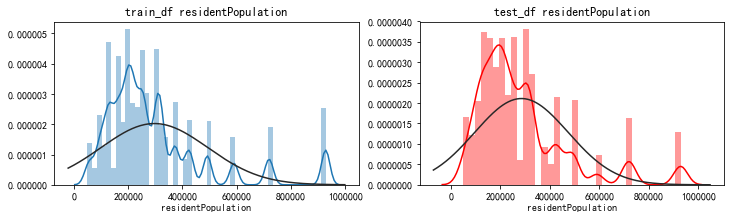

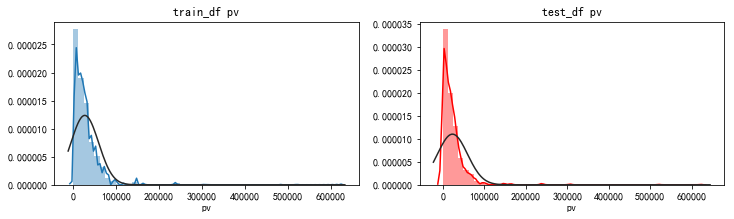

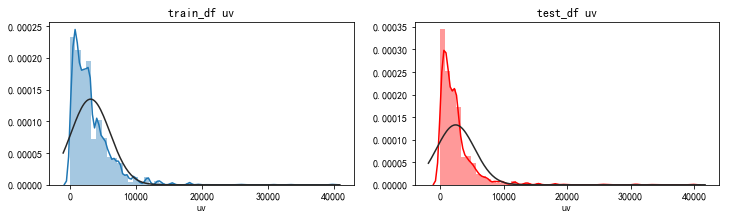

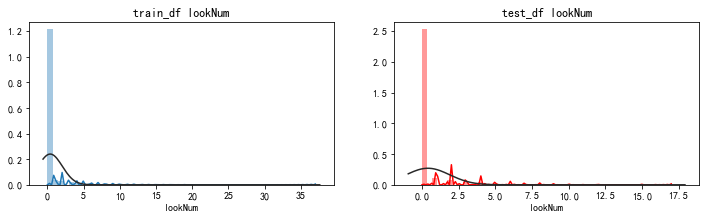

In [53]:
for col_3 in numerical_col:
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,3))
    sns.distplot(train_df[col_3],fit=norm,ax=ax1)
    ax1.set_title('train_df %s'%col_3)
    sns.distplot(test_df[col_3],fit=norm,ax=ax2,color='red')
    ax2.set_title('test_df %s'%col_3)
    plt.show()

可以看到，有一些特征有明显的长尾现象，由部分离群点的存在而造成的

In [54]:
##area
train_df = train_df[(train_df['area']>=10)&(train_df['area']<=200)]

## 5.Deep Cleaning 

In [55]:
train_df[(train_df['region']=='RG00011')&(train_df['area']>=150)&
                       (train_df['tradeMoney']<=2000)]

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney
6080,100306138,151.76,未知方式,3室2厅2卫,低,6,南,其他,XQ03433,SH,...,0,0.0,1190,50,250864,1713,309,0,2018/11/13,1900.0


In [56]:
##组合特征进行筛选
#list(train_df[['region','tradeMoney','area']].groupby('region'))
train_df.drop(train_df[(train_df['region']=='RG00001')&(train_df['area']>=100)&
                       (train_df['tradeMoney']<=2000)].index,inplace=True)
# train_df.drop(train_df[(train_df['region']=='RG00001')&(train_df['area']<=10)&
#                     (train_df['tradeMoney']>=3000)].index,inplace=True)
train_df.drop(train_df[(train_df['region']=='RG00002')&(train_df['area']>=100)&
                       (train_df['tradeMoney']<=1000)].index,inplace=True)
# train_df.drop(train_df[(train_df['region']=='RG00003')&(train_df['area']<=10)&
#                        (train_df['tradeMoney']>=4000)].index,inplace=True)
train_df.drop(train_df[(train_df['region']=='RG00003')&(train_df['area']>=150)&
                       (train_df['tradeMoney']<=2000)].index,inplace=True)
train_df.drop(train_df[(train_df['region']=='RG00004')&(train_df['area']>=100)&
                       (train_df['tradeMoney']<=1000)].index,inplace=True)
train_df.drop(train_df[(train_df['region']=='RG00005')&(train_df['area']>=150)&
                       (train_df['tradeMoney']<=2000)].index,inplace=True)
train_df.drop(train_df[(train_df['region']=='RG00006')&(train_df['area']>=100)&
                       (train_df['tradeMoney']<1000)].index,inplace=True)
train_df.drop(train_df[(train_df['region']=='RG00008')&(train_df['area']>100)&
                       (train_df['tradeMoney']<=2000)].index,inplace=True)
train_df.drop(train_df[(train_df['region']=='RG00009')&(train_df['area']>=100)&
                       (train_df['tradeMoney']<=1000)].index,inplace=True)
# train_df.drop(train_df[(train_df['region']=='RG00010')&(train_df['area']>=100)&
#                        (train_df['tradeMoney']<=2000)].index,inplace=True)
train_df.drop(train_df[(train_df['region']=='RG00011')&(train_df['area']>=150)&
                       (train_df['tradeMoney']<=2000)].index,inplace=True)

## -----------------------------------baseline--------------------------------

In [57]:
from sklearn.preprocessing import LabelEncoder

In [58]:
data_df = pd.concat([train_df,test_df])
data_df.shape

(41638, 51)

In [59]:
train_nunique = train_df[categorical_col].nunique().sort_values(ascending=False)
test_nunique = test_df[categorical_col].nunique()
nunique_values = pd.concat([train_nunique,test_nunique],keys=['train_nunique','test_nunique'],axis=1,sort=False)
nunique_values

,train_nunique,test_nunique
communityName,4017,2469
tradeTime,361,331
buildYear,80,67
houseType,69,31
plate,66,63
region,15,14
houseToward,10,8
houseDecoration,4,4
rentType,4,3
houseFloor,3,3


In [60]:
data_df.drop(['city','ID','communityName','tradeMoney'],axis=1,inplace=True)

In [61]:
##--preprocessing--
#--rentType--
data_df['rentType'].replace('--','未知方式',inplace=True)

#--buildYear--
median_build = data_df.loc[data_df['buildYear']!='暂无信息','buildYear'].median()
data_df['buildYear'].replace("暂无信息",median_build,inplace=True)
data_df['buildYear'] = data_df["buildYear"].astype(int)
data_df["buildYear"] = 2019-data_df["buildYear"]

#--houseType--
data_df['rooms'] = data_df['houseType'].apply(lambda x:x.split('室')[0][-1]).astype(int)
data_df['halls'] = data_df['houseType'].apply(lambda x:x.split('厅')[0][-1]).astype(int)
data_df['bathrooms'] = data_df['houseType'].apply(lambda x:x.split('卫')[0][-1]).astype(int)
data_df['rooms_bathrooms'] = (data_df['bathrooms']+1)/(data_df['rooms']+1)
data_df['rooms_bathrooms'] = data_df['rooms_bathrooms'].astype(int)
data_df.drop('houseType',axis=1,inplace=True)

In [62]:
#--tradeTime--
data_df['Month'] = data_df['tradeTime'].apply(lambda x:x.split('/')[1]).astype(int)
data_df['Date'] = data_df['tradeTime'].apply(lambda x:x.split('/')[2]).astype(int) 
data_df.drop('tradeTime',axis=1,inplace=True)

In [63]:
#--rentType--
# data_df.loc[(data_df['rentType']!='未知方式')&(data_df['area']<100)&
#                       (data_df['rooms']>=5),'rentType'] = '合租'  ##  2.
# data_df.loc[(data_df['rentType']=='未知方式') & (data_df['area']>=100),'rentType'] = '整租'##  1.
# data_df.loc[(data_df['rentType']=='未知方式') & (data_df['rooms']<5)& 
#             (data_df['area']<100) & (data_df['rooms_bathrooms']==1),'rentType'] = '整租'## 3.
# data_df.loc[(data_df['rentType']=='未知方式') & (data_df['area']<=100) & 
#             (data_df['rooms']<=1) & (data_df['rooms_bathrooms']==0),'rentType'] = '整租'##  4.
# data_df.loc[(data_df['rentType']=='未知方式') & (data_df['area']<=30) & 
#             (data_df['rooms']>1) & (data_df['rooms_bathrooms']==0),'rentType'] = '合租'##   5.
# data_df.loc[(data_df['rentType']=='未知方式') & (data_df['area']>30) & (data_df['area']<=100)&
#             (data_df['rooms']>1) & (data_df['rooms_bathrooms']==0),'rentType'] = '整租'##   6.

In [64]:
#data_df[data_df['rentType']=='整租']

In [65]:
categorical_new = [col for col in data_df.columns if data_df[col].dtypes=='object']
data_df[categorical_new].nunique().sort_values(ascending=False)

plate              66
region             15
houseToward        10
houseDecoration     4
rentType            3
houseFloor          3
dtype: int64

In [66]:
from sklearn.preprocessing import LabelEncoder

Label_list = ['plate','region','houseToward']
for col_4 in Label_list:
    data_df[col_4] = data_df[col_4].astype(str)
    data_df[col_4] = LabelEncoder().fit_transform(data_df[col_4])
    
Onehot_list = ['houseDecoration','rentType','houseFloor']
for col_5 in Onehot_list:
    data_df[col_5] = data_df[col_5].astype(str)
    inter_col = pd.get_dummies(data_df[col_5])
    data_df.drop(col_5,axis=1,inplace=True)
    data_df = pd.concat([data_df,inter_col],axis=1)

In [67]:
print(data_df.shape)
print(train_df.shape)
print(test_df.shape)

(41638, 58)
(39169, 51)
(2469, 50)


In [68]:
#train and test
#Y = np.expm1(train_df['tradeMoney'])
Y = train_df['tradeMoney']
m = len(Y)
X = data_df.iloc[:m,:]
X_test = data_df.iloc[m:,:]

In [69]:
print(X.shape)
print(X_test.shape)

(39169, 58)
(2469, 58)


In [70]:
from sklearn.metrics import r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold,cross_val_score
import time

In [71]:
params = {
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'min_child_samples':20,
    'objective': 'regression',
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "feature_fraction": 0.8,
    "bagging_freq": 1,
    "bagging_fraction": 0.85,
    "bagging_seed": 23,
    "metric": 'rmse',
    "lambda_l1": 0.2,
    "nthread": 4,
}

In [72]:
folds = KFold(n_splits=5,shuffle=True,random_state=2019)
oof_lgb = np.zeros(len(X))
pred_lgb = np.zeros(len(X_test))
start = time.time()
for fold_,(trn_idx,val_idx) in enumerate(folds.split(X.values,Y.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(X.iloc[trn_idx],label=Y.iloc[trn_idx])
    
    val_data = lgb.Dataset(X.iloc[val_idx],label=Y.iloc[val_idx])
    

    num_round = 10000
    clf = lgb.train(params,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
        
    oof_lgb[val_idx] = clf.predict(X.iloc[val_idx], num_iteration=clf.best_iteration)
    pred_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV Score: {:<8.5f}".format(r2_score( Y, oof_lgb)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 877.462	valid_1's rmse: 928.862
[1000]	training's rmse: 794.941	valid_1's rmse: 889.605
[1500]	training's rmse: 744.657	valid_1's rmse: 873.815
[2000]	training's rmse: 707.281	valid_1's rmse: 864.203
[2500]	training's rmse: 677.498	valid_1's rmse: 858.861
[3000]	training's rmse: 651.472	valid_1's rmse: 854.738
[3500]	training's rmse: 629.045	valid_1's rmse: 851.676
[4000]	training's rmse: 608.663	valid_1's rmse: 849.478
[4500]	training's rmse: 590.583	valid_1's rmse: 848.344
[5000]	training's rmse: 574.232	valid_1's rmse: 847.572
[5500]	training's rmse: 559.07	valid_1's rmse: 846.355
[6000]	training's rmse: 545.281	valid_1's rmse: 846.176
Early stopping, best iteration is:
[5853]	training's rmse: 549.291	valid_1's rmse: 845.957
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 875.672	valid_1's rmse: 926.799
[1000]	training's rmse: 792.419	valid_1'

In [73]:
def online_score(pred):
    print("预测结果最大值：{},预测结果最小值：{}".format(pred.max(),pred.min()))
    # a榜测分
    conmbine1 = pd.read_csv("D:/DataAnalysis/2019未来高校AI挑战赛_城市-房产租金预测/sub_a_913.csv",engine = "python",header=None)
    score1 = r2_score(pred, conmbine1.values)
    print("对比913分数:{}".format(score1))

In [74]:
online_score(pred_lgb)

预测结果最大值：15723.500485198418,预测结果最小值：1104.1008296704451
对比913分数:0.954738247507657
